In [50]:


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Tuple, List
import math as mt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
sns.set()

import dslab
from dslab.visualization.visualize import distribution
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# looking into some of the variables we see that the "MasVnrArea" variable and the "LotFrontage" variable are essentially numerical data just with an Na in some cases indicating that that particular
# feature is not present in that house, justifying us converting it to an integer feature and setting the Na's to 0
def toint64(a, Na=0):
    try:
        return np.int64(a)
    except ValueError:
        return Na

vtoint64 = np.vectorize(toint64)

In [52]:
dataloc = {
'folder' : "engsci-205-machine-intelligence-assigment-2021",
'trainfile' : "train.csv",
'testfile' : "test.csv"
}

dataloc['trainloc'] = dataloc['folder'] + os.sep + dataloc['trainfile']
dataloc['testloc'] = dataloc['folder'] + os.sep + dataloc['testfile']

df = pd.read_csv(dataloc['trainloc'],
                index_col=0,
                na_values='Na',
                keep_default_na=False)

df_testing = pd.read_csv(dataloc['testloc'],
                index_col=0,
                na_values='Na',
                keep_default_na=False)

# Transformer Classes #
Below we have a series of classes that are combined to transform our data. Here is a list of each transformer explaining its purpose:
* ## `CatAttrToInt` ##
    - This class converts the variables listed in self.features_to_transform from objects into integers. The reason for this is that these features have can have Na values, however, this is only due to the fact that the data point in question does not have that quantity (e.g. Masonary Veneer area = Na when the house doesn't have a Masonary Veneer attached to it) meaning that the Na is equivalent to it having 0 area.
* ## `LogTransformer` ##
    - Due to many of the variables being very right skewed, this log transformer normalises them, making them more applicable for the ML model. However, since many of these variables are right skewed with a number of datapoints at 0, we use log(1+x) instead of log(x) to avoid evaluating log(0)
* ## `AttrSelector` ##
    - This class separates the dataset into Categorical or Numerical Variables using the dataframe.select_dtypes method 
    - if `select_ints = True` then this selects numerical variables, otherwise it sekects categorical
* ## `NewAttrAdder` ##
    - This adds the following new variables to the dataset:
        - `YrMoSold` : The date the house was sold with the month as a decimal
        - `LotLivingRatio` : Ratio of living area (i.e. living area above ground) to Lot area for the house
        - `AvgRmArea` : The average area of the rooms in the house, measured as Total Room Area above ground / Total number of rooms

* ## `OrdLabelEncoder` ##
    - Selects the categorical features that are being label encoded and label encodes them according to the ordering given in label_orders
    - these features were chosen to be label encoded since their categories accept a natural order to them (e.g. 'quality variables' can be ranked from poor to excellent)

* ## `SelectOneHotEncdoder` ##
    - Selects all the categorical features that are not being label encoded due to not having any natural order to them, and encodes them via one hot encoding
    - also adds a `get_feature_names` method for easy labelling of variables

* ## `PipelineMod` ##
    - Adds a `get_feature_names` method to pipelines

* ## `FeatureUnionMod` ##
    - Adds a `features` method which writes down the features names without modifying them (unlike the normal `get_feature_names` in feature union which appends extra information to them)

These classes are combined to form the full data pipeline which is visualised below (with parellel operations done with feature unions and serial operations done with pipelines)

<img src="TransformerDiagram.png" alt="drawing" width="1000"/>


In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

label_orders = {
    'ExterQual' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual' : ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond' : ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure' : ['NA', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1' : ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2' : ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'CentralAir' : ['Na','N', 'Y'],
    'KitchenQual' : ['NA','Po','Fa', 'TA', 'Gd', 'Ex'], 
    'Functional' : ['NA','Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu' : ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish' : ['NA', 'Unf', 'RFn', 'Fin'],
    'GarageQual' : ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond' : ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PoolQC' : ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence' : ['NA', 'MnWw','GdWo', 'MnPrv', 'GdPrv'],
}   

class CatAttrToInt(BaseEstimator, TransformerMixin): # 

    features_to_transform = ["MasVnrArea", "LotFrontage",'BsmtFinSF1','BsmtFinSF2','BsmtFullBath','BsmtHalfBath','BsmtUnfSF','GarageArea','GarageCars','TotalBsmtSF']

    def fit(self, X: pd.DataFrame, y=None):
        return self
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        Xc = X.copy()
        try:
            for featr in self.features_to_transform:
                Xc[featr] = vtoint64(X[featr])
        except KeyError:
            pass
        return Xc

    def inverse_transform(self, X: pd.DataFrame):
        Xc = X.copy()
        try:
            func = lambda x : 'Na' if x == 0 else str(x)
            for featr in self.features_to_transform:
                Xc[featr] =  np.vectorize(func)(Xc[featr])
            return Xc
        except KeyError:
            return Xc
        

class LogTransformer(BaseEstimator, TransformerMixin):
    log_features = ["MSSubClass", "LotFrontage", "LotArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "WoodDeckSF", "OpenPorchSF","3SsnPorch", "EnclosedPorch", "MiscVal"]
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xc = X.copy()
        for f in self.log_features:
            Xc[f] = np.log(1+Xc[f])
        return Xc.values


class AttrSelector(BaseEstimator, TransformerMixin): #
    attrs = None
    def __init__(self, select_ints: bool=False) -> None:
        self.select_ints = select_ints
        
    def fit(self, X, y=None):
        if self.select_ints:
            Xc = X.select_dtypes(include="int64")
            self.attrs = list(Xc.columns)
            
        else:
            Xc = X.select_dtypes(exclude="int64")
            self.attrs = list(Xc.columns)
        return self

    def transform(self, X: pd.DataFrame):
        if self.select_ints:
            Xc = X.select_dtypes(include="int64")
            
            
        else:
            Xc = X.select_dtypes(exclude="int64")
            
            
        return Xc



class NewAttrAdder(BaseEstimator, TransformerMixin):
    
        new_features = ['YrMoSold','LotLivingRatio', 'AvgRmArea']

        def fit(self, X, y=None):
            return self
        
        def transform(self, X, y=None):

            YrMoSold = X['YrSold'] + (X['MoSold'])/12
            LotLivingRatio = np.float64(X['GrLivArea'])/X['LotArea']
            AvgRmArea = np.float64(X['GrLivArea'])/X['TotRmsAbvGrd']
            
            return pd.DataFrame(np.c_[X.values, YrMoSold, LotLivingRatio, AvgRmArea], columns = list(X.columns)+self.new_features)


class OrdLabelEncoder(BaseEstimator, TransformerMixin):

    cats = [label_orders[k] for k in label_orders.keys()]
    cols = [k for k in label_orders.keys()]
    le = OrdinalEncoder(categories=cats)#,handle_unknown= 'use_encoded_value', unknown_value=0)
    
    def fit(self, X, y=None):
        Xc = X[self.cols]
        self.le.fit(Xc)
        return self

    def transform(self, X, y=None):
        Xc = X[self.cols]
        return self.le.transform(Xc)

    def get_feature_names(self):
        return self.cols

class SelectOneHotEncoder(BaseEstimator, TransformerMixin):

    droppedcols = [k for k in label_orders.keys()]
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    cols = None
    def fit(self, X, y=None):
        Xc = X.drop(columns=self.droppedcols)
        self.cols = list(Xc.columns)        
        self.ohe.fit(Xc)
        return self

    def transform(self, X, y=None):
        Xc = X.drop(columns=self.droppedcols)
        
        return self.ohe.transform(Xc)
    
    def get_feature_names(self):
        return self.ohe.get_feature_names(self.cols)
    
class PipelineMod(Pipeline):
    def get_feature_names(self):
        pass

class FeatureUnionMod(FeatureUnion):
    def features(self):
        return [s.split("__")[-1] for s in self.get_feature_names()]



In [54]:

from sklearn.preprocessing import StandardScaler

cat_encoder = FeatureUnionMod([
    ("OneHotEncoding", SelectOneHotEncoder()), 
    ("OrdinalEncoding", OrdLabelEncoder()),
    
])

cat_pipe = PipelineMod([
    ('select_cats', AttrSelector()),
    ('encode_values', cat_encoder)
])
cat_pipe.get_feature_names = lambda: cat_pipe.steps[1][1].features()

num_pipe = PipelineMod([
    ('select_ints', AttrSelector(select_ints=True)),
    ('add_attrs', NewAttrAdder()),
    ('log_transform', LogTransformer()),
    # ('Standard Scaler', StandardScaler()) # this was removed since it ended up increasing the out of sample error
])
num_pipe.get_feature_names = lambda: num_pipe.steps[0][1].attrs + num_pipe.steps[1][1].new_features

full_processor = FeatureUnionMod([
    ('cat_pipe',cat_pipe),
    ('num_pipe', num_pipe)
])


full_pipeline = PipelineMod([
    ('change_cat_to_int', CatAttrToInt()),
    ("process_data", full_processor)
])


full_pipeline.get_feature_names = lambda: full_pipeline.steps[1][1].features()

In [55]:
X_train = df.drop(columns="SalePrice") # feature variables
y = np.log(df["SalePrice"]) # use the log of the saleprice as the predictor


# Transform all the data, fitting the transformer to the test set
Xtr = full_pipeline.fit_transform(X_train) 
df_tr = pd.DataFrame(Xtr, columns=full_pipeline.get_feature_names())
Xtr_test = full_pipeline.transform(df_testing)
test_tr = pd.DataFrame(Xtr_test, columns=full_pipeline.get_feature_names())

# Model Fitting #
Now using the transformed data, we fitted 10 models with default parameters to the data and found the mean out-of-sample rmse for all of the models

In [56]:
from sklearn.base import RegressorMixin
from sklearn.utils.testing import all_estimators
from sklearn.model_selection import cross_val_score

all_regressors = [reg for reg in all_estimators() if issubclass(reg[1], RegressorMixin)]
ixs = [1,5,7,12,14,18,22,28,35,44]
regressors = [all_regressors[i] for i in ixs]
rmses = []
for r in regressors:
    reg = r[1]()
    scores = cross_val_score(reg, df_tr, np.ravel(y), scoring="neg_mean_squared_error", cv=10)
    rmse = np.sqrt(-scores)
    rmses.append(np.mean(rmse))

/opt/anaconda3/envs/term121x_env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/term121x_env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/term121x_env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/term121x_env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/term121x_env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: L

In [57]:
rmses_df = pd.DataFrame(np.array([[r[0] for r in regressors],rmses]).T, columns=["name", 'rmse']) # Create a dataframe with each regrossor and its mean rmse
rmses_df.rmse = np.float64(rmses_df.rmse)
min3 = rmses_df.nsmallest(3, 'rmse') # choose the regressors with the 3 smallest mean rmses

preds = []
best_res: List[RegressorMixin] = [regressors[i][1]() for i in min3.index] # initialise each of the best models
names = [regressors[i][0] for i in min3.index] 
for r in best_res:
    r.fit(X=df_tr, y=y)
    preds.append(r.predict(df_tr)) # fit and predict for all 3 of the best models

preds = np.array(preds)
names

In [58]:
var_importance = {"variable" : list(df_tr.columns)}
var_importance.update({n : r.feature_importances_ for n,r in zip(names,best_res)}) 
feature_importances = pd.DataFrame(var_importance) # make a df listing all the feature importances for all 3 models
for n in names:
    print(feature_importances[['variable',n]].nlargest(10, n))


         variable  GradientBoostingRegressor
299   OverallQual                   0.421848
311     GrLivArea                   0.154405
307   TotalBsmtSF                   0.050692
288   KitchenQual                   0.048379
320    GarageCars                   0.039762
279     ExterQual                   0.032501
291  GarageFinish                   0.028429
281      BsmtQual                   0.023689
304    BsmtFinSF1                   0.022276
298       LotArea                   0.017445
        variable  RandomForestRegressor
299  OverallQual               0.544134
311    GrLivArea               0.107344
307  TotalBsmtSF               0.043723
320   GarageCars               0.041076
321   GarageArea               0.022712
308     1stFlrSF               0.022497
304   BsmtFinSF1               0.020297
301    YearBuilt               0.015899
300  OverallCond               0.012949
287   CentralAir               0.012601
        variable  AdaBoostRegressor
299  OverallQual           0.

## feature importance analysis
We see above that for the Gradient boosting algorithm and Random Forest, Overall Quality, Living area above ground and Total Basement area are the top 3 most significant features while for Ada Boost, the most import features are Living area above ground, Overall Quality and Kitchen Quality are the top 3 most important features. (note taht Living area ais a log variable in the dataset)

The joint plots of these variables to the log sales price is shown below:

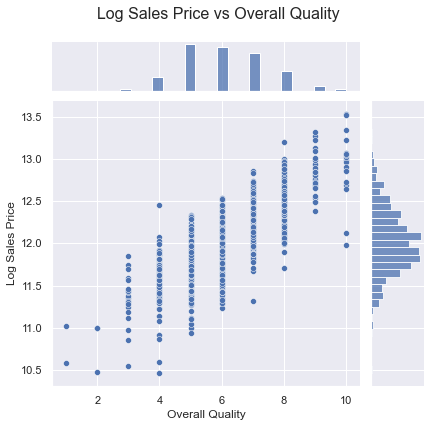

In [59]:
plot = sns.jointplot(y=y, x=df.OverallQual)
plot.fig.suptitle("Log Sales Price vs Overall Quality", size=16)
plot.fig.subplots_adjust(top=.9)
plot.set_axis_labels(xlabel="Overall Quality", ylabel = "Log Sales Price")
plt.show()

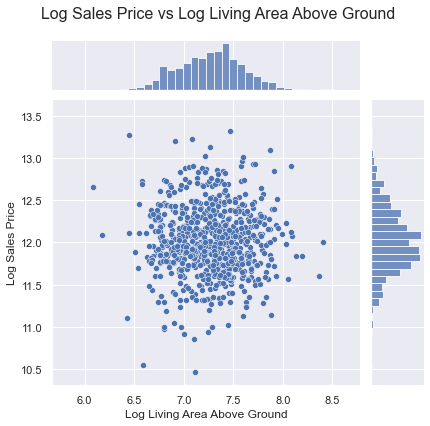

In [60]:
plot = sns.jointplot(y=y, x=df_tr.GrLivArea)
plot.fig.suptitle("Log Sales Price vs Log Living Area Above Ground", size=16)
plot.fig.subplots_adjust(top=.9)
plot.set_axis_labels(xlabel="Log Living Area Above Ground", ylabel = "Log Sales Price")
plt.show()

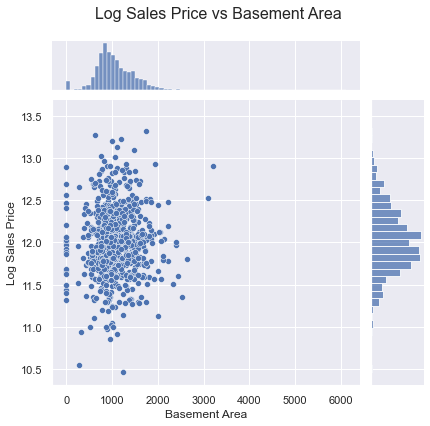

In [61]:
plot = sns.jointplot(y=y, x=df_tr.TotalBsmtSF)
plot.fig.suptitle("Log Sales Price vs Basement Area", size=16)
plot.fig.subplots_adjust(top=.9)
plot.set_axis_labels(xlabel="Basement Area", ylabel = "Log Sales Price")
plt.show()

## Error Analysis ##

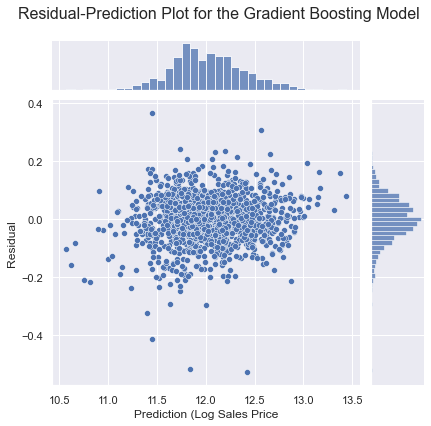

In [62]:
errors_gboost = pd.DataFrame({
    "prediction" : preds[0],
    "residual" : np.array(y) - np.array(preds[0])
})
plot = sns.jointplot(errors_gboost.prediction, errors_gboost.residual)
plot.fig.suptitle("Residual-Prediction Plot for the Gradient Boosting Model", size=16)
plot.fig.subplots_adjust(top=.9)
plot.set_axis_labels(ylabel="Residual", xlabel = "Prediction (Log Sales Price")
plt.show()

Above we see the Errors made by the Gradient boosting model. In them we see that the model overall has good predictions with its errors being underpredcitons and overpredictions about 50% of the time each

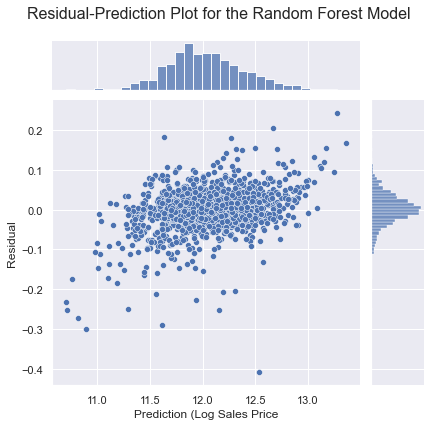

In [63]:
errors_rf = pd.DataFrame({
    "prediction" : preds[1],
    "residual" : np.array(y) - np.array(preds[1])
})
plot = sns.jointplot(errors_rf.prediction, errors_rf.residual)
plot.fig.suptitle("Residual-Prediction Plot for the Random Forest Model", size=16)
plot.fig.subplots_adjust(top=.9)
plot.set_axis_labels(ylabel="Residual", xlabel = "Prediction (Log Sales Price")
plt.show()

The random forest model has a similar error profile, however it tends to overpredict slightly more often then it does under

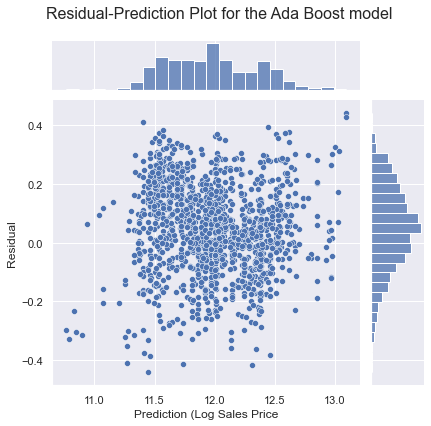

In [64]:
errors_adaboost = pd.DataFrame({
    "prediction" : preds[2],
    "residual" : np.array(y) - np.array(preds[2])
})
plot = sns.jointplot(errors_adaboost.prediction, errors_adaboost.residual)
plot.fig.suptitle("Residual-Prediction Plot for the Ada Boost model", size=16)
plot.fig.subplots_adjust(top=.9)
plot.set_axis_labels(ylabel="Residual", xlabel = "Prediction (Log Sales Price")
plt.show()

The adaboost model shows a very normally distributed set of residuals which shows a much more uniform spread of error than that of the both other. It seems to almsot exactly over/under predict 50% of the time

## Hyperparameter Tuning
Below we perform hyperparameter tuning on all of the models which performed best in the kfold cross validation. Analysis of each of them revealed that Gradient Boosting was the best performing model with optimal hyperparameters:
   - learning_rate: 0.1,
   - max_depth: 5
   - min_samples_split: 4
   - n_estimators: 45

In [65]:
# GRADIENT BOOSTING 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
CV=10
params_gb = {
    'max_depth' : [2,3,5],
    'learning_rate' : [0.01,0.02,0.05, 0.1],
    'n_estimators' : [3, 10, 30,45],
    'min_samples_split' : [2,4]
}

gb = GradientBoostingRegressor()
gsearch_gb = GridSearchCV(gb, params_gb, cv=CV, scoring="neg_mean_squared_error")
gb_opitmal = gsearch_gb.fit(df_tr, y)




In [ ]:
print(f"best params : {gb_opitmal.best_params_}\nbest error : {-gb_opitmal.best_score_}")

best params : {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 45}
best score : 0.017456692837941195


In [ ]:
# Random Forest

params_rf = {
    # 'loss' : ['squared_error', 'absolute_error'],
    'max_features' : [2,4,6,8],
    'n_estimators' : [3, 10, 30],
    'min_samples_split' : [2,4]
}

rf = RandomForestRegressor()
gsearch_rf = GridSearchCV(rf, params_rf, cv=CV, scoring="neg_mean_squared_error")
rf_opitmal = gsearch_rf.fit(df_tr, y)




In [ ]:
print(f"best params : {rf_opitmal.best_params_}\nbest error : {-rf_opitmal.best_score_}")

best params : {'max_features': 8, 'min_samples_split': 4, 'n_estimators': 30}
best score : 0.024866336350314672


In [ ]:
# Ada Boost

params_ada = {
    'loss' : ['linear', 'square'],
    'learning_rate' : [0.01, 0.02,0.05, 0.1],
    'n_estimators' : [3, 10, 30, 45],
    
}


ada = AdaBoostRegressor()
gsearch_ada = GridSearchCV(ada, params_ada, cv=CV, scoring="neg_mean_squared_error")
ada_opitmal = gsearch_ada.fit(df_tr, y)





In [ ]:
print(f"best params : {ada_opitmal.best_params_}\nbest error : {-ada_opitmal.best_score_}")

best params : {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 45}
best score : 0.03523199050885704


In [ ]:
# BEST PREDICTOR
gb_final = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=4, n_estimators=30)
gb_final.fit(df_tr.values, y)

predictions_df = pd.DataFrame({
    'Id' : np.arange(1461, 2920), 
    'SalePrice' : np.exp(gb_final.predict(test_tr))

})
predictions_df.set_index('Id', inplace=True)

# Test Predictions saved to submission.csv
predictions_df.to_csv('submission.csv')

NameError: name 'GradientBoostingRegressor' is not defined